In [2]:
!pip install kaggle tensorflow numpy matplotlib

In [3]:
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()  # This will prompt you to upload `kaggle.json`
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure the API key

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download ahmedhamada0/brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection
License(s): copyright-authors
100% 84.0M/84.0M [00:06<00:00, 23.2MB/s]
100% 84.0M/84.0M [00:06<00:00, 14.5MB/s]


In [5]:
!unzip brain-tumor-detection.zip -d brain-tumor-dataset

Archive:  brain-tumor-detection.zip
  inflating: brain-tumor-dataset/Br35H-Mask-RCNN/TEST/annotations_test.json  
  inflating: brain-tumor-dataset/Br35H-Mask-RCNN/TEST/y701.jpg  
  inflating: brain-tumor-dataset/Br35H-Mask-RCNN/TEST/y702.jpg  
  inflating: brain-tumor-dataset/Br35H-Mask-RCNN/TEST/y703.jpg  
  inflating: brain-tumor-dataset/Br35H-Mask-RCNN/TEST/y704.jpg  
  inflating: brain-tumor-dataset/Br35H-Mask-RCNN/TEST/y705.jpg  
  inflating: brain-tumor-dataset/Br35H-Mask-RCNN/TEST/y706.jpg  
  inflating: brain-tumor-dataset/Br35H-Mask-RCNN/TEST/y707.jpg  
  inflating: brain-tumor-dataset/Br35H-Mask-RCNN/TEST/y708.jpg  
  inflating: brain-tumor-dataset/Br35H-Mask-RCNN/TEST/y709.jpg  
  inflating: brain-tumor-dataset/Br35H-Mask-RCNN/TEST/y710.jpg  
  inflating: brain-tumor-dataset/Br35H-Mask-RCNN/TEST/y711.jpg  
  inflating: brain-tumor-dataset/Br35H-Mask-RCNN/TEST/y712.jpg  
  inflating: brain-tumor-dataset/Br35H-Mask-RCNN/TEST/y713.jpg  
  inflating: brain-tumor-dataset/Br35H-Ma

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_squared_error
import cv2

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
source_dir = "brain-tumor-dataset/no"
train_dir = "brain-tumor-dataset/train/no"
val_dir = "brain-tumor-dataset/val/no"

# Create directories if not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Get all image filenames
all_images = [f for f in os.listdir(source_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.JPG'))]

train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)

for img in train_images:
    shutil.copy(os.path.join(source_dir, img), os.path.join(train_dir, img))

for img in val_images:
    shutil.copy(os.path.join(source_dir, img), os.path.join(val_dir, img))

print("Dataset split complete.")

Dataset split complete.


In [9]:
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_gen.flow_from_directory(
    "brain-tumor-dataset/train",
    target_size=(128, 128),
    batch_size=32,
    class_mode='input'
)

val_generator = data_gen.flow_from_directory(
    "brain-tumor-dataset/val",
    target_size=(128, 128),
    batch_size=32,
    class_mode='input'
)


Found 1200 images belonging to 1 classes.
Found 300 images belonging to 1 classes.


In [10]:
def build_autoencoder():
    input_img = Input(shape=(128, 128, 3))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [11]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
autoencoder.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 172ms/step - loss: 0.0940 - val_loss: 0.0217
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0199 - val_loss: 0.0169
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0170 - val_loss: 0.0152
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0147 - val_loss: 0.0138
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0141 - val_loss: 0.0129
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0126 - val_loss: 0.0122
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0126 - val_loss: 0.0117
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0120 - val_loss: 0.0110
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0114 - val_loss: 0.0107
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0104 - val_loss: 0.0101
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0101 - val

In [13]:
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
autoencoder.save("autoencoder_model.h5")

In [14]:
def detect_anomalies(model, test_images):
    anomalies = []
    for img in test_images:
        original = cv2.resize(img, (128, 128))
        original = original.astype('float32') / 255.0
        reconstructed = model.predict(np.expand_dims(original, axis=0))[0]

        mse = mean_squared_error(original.flatten(), reconstructed.flatten())
        if mse > 0.005:  # Adjust threshold accordingly
            anomalies.append((original, reconstructed, mse))
    return anomalies


In [15]:
def visualize_results(anomalies):
    for original, reconstructed, mse in anomalies[:5]:
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(original)
        axs[0].set_title("Original Image")
        axs[1].imshow(reconstructed)
        axs[1].set_title(f"Reconstructed (MSE: {mse:.4f})")
        plt.show()

In [17]:
test_images = [cv2.imread(os.path.join("brain-tumor-dataset/yes", img)) for img in os.listdir("brain-tumor-dataset/yes")]

anomalies_detected = detect_anomalies(autoencoder, test_images)
print(len(anomalies_detected))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

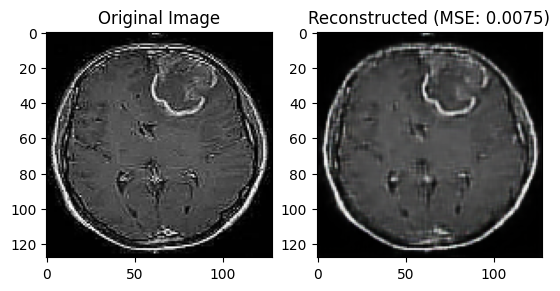

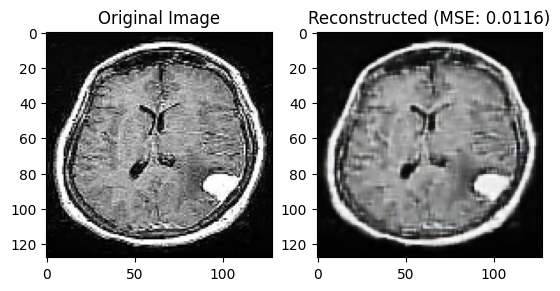

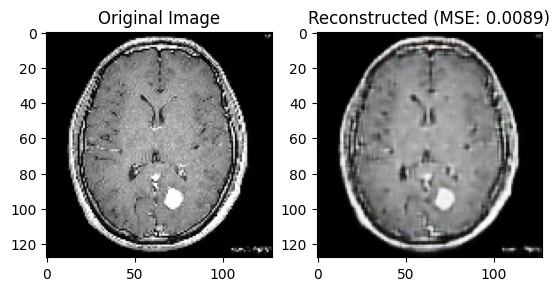

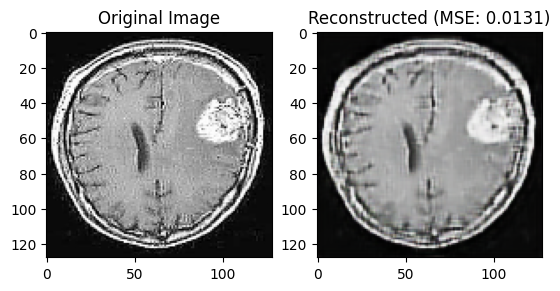

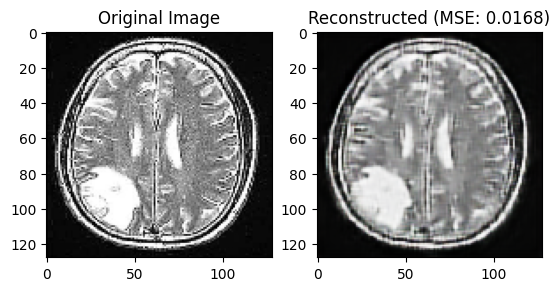

In [18]:
visualize_results(anomalies_detected)